# Machine Learning for Brain Computer Interfaces

George Panagopoulos (gpanagopoulos@iit.demokritos.gr)
[CRU](http://cru.iit.demokritos.gr/)


### Introduction

The advance of Brain Computer Interfaces - BCI is a challenge for several scientific fields, ranging from digital signal processing, machine learning to neuroscience, psychology etc. 
Due to the variabiligy inherent in human brain, a BCI must either adapt to a specific subject in order to produce sufficient resutls or identify and use patterns of brain activation that apply to every subject. That is where Machine Learning gets into play.

The aim of the current exercise is double. Initially we present a simple way to handle and visualize EEG data using python, and secondly we examine a basic machine learning approach to identify when the subject closes the right or the left eye based on his EEG activity.

### Visualization
The first step is to visualize the EEG time series that were recording during the experiment we run. We arbitrarily choose one of the channels for subject 1 and session 1.

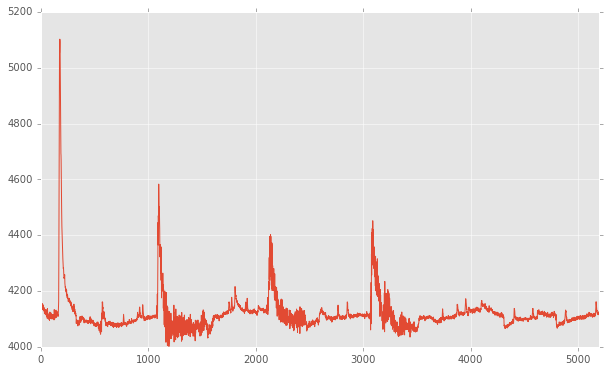

In [5]:
import os
os.chdir('C:\Users\Giwrgos\Documents\GitHub\Demokritos-BCI-Summer-School-2016')

import pandas as pd
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import matplotlib.pyplot as plt

# Load the matrix with the recordings of Subject 1 in Session 1
raw = pd.read_csv("Recordings\\train\Sub1_Ses1_raw.csv")
# Visualize the second column, which corresponds to the EEG recording of channel F7
ax = raw.ix[:,1].plot()

One can clearly see some strong EEG oscilations. This might indicate brain activation due to the blinking or due to the stimuli. We can also add more than one EEG channel in our plot while drawing some vertical lines to indicate when did the subject blinked with his right or left eye. This should clarify whether this patterns are prevelent thoughout the brain and if they are indeed caused by the experimental intervention.

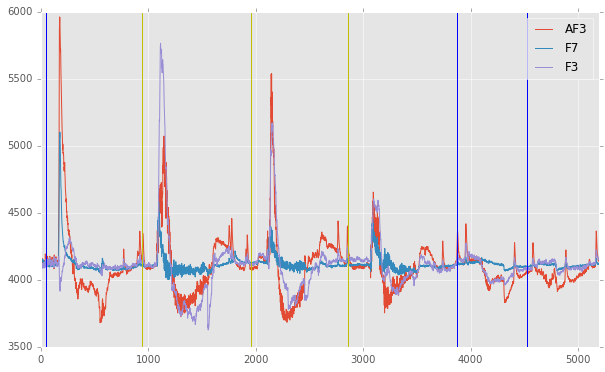

In [13]:
#Visualize the three channels together 
ax = raw.ix[:,0:3].plot()

# Read the time series events (-1 for closing left eye , 1 for right eye)
events = pd.read_csv("Recordings\\train\Sub1_Ses1_events.csv",header = None )

# Find when the left events happen (at what sample)
left_events_idx = list(events.ix[events.ix[:,0]<0].index)
# Push the first stimuli a little further to be seen in the plot
left_events_idx[0] = left_events_idx[0]+50
# Add them in the EEG plot
for e in left_events_idx:
    ax.axvline(x=e, color='b')

# Do the same for right events
right_events_idx = list(events.ix[events.ix[:,0]>0].index)
for e in right_events_idx:
    ax.axvline(x=e, color='y')

From the plot we can conclude that indeed the spikes must have been caused by the stimuli. The time between the stimuli and the high oscillation corresponds roughly to 100 samples which is close to 1s, given that the sampling rate of Emotiv Epoc+ is 128 Hz. We can also conclude that the subject might got used to the stimuli as the experiment kept on going, that is why the latter activations are less significatn. 

### Cleaning

Using describe we can easily extract some summary stats for every variable in our dataset.

In [15]:
raw.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,FC6,F4,F8,AF4
count,5192.000000,5192.00000,5192.000000,5192.000000,5192.000000,5192.000000,5192.000000,5192.000000,5192.000000,5192.000000,5192.000000,5192.000000
mean,4105.684089,4117.83276,4113.557939,4041.407689,4108.184781,4116.456482,4119.115700,4118.216685,4123.307159,4122.967781,4057.691320,4124.745268
std,228.003174,71.46573,216.604324,882.555333,218.875956,85.693514,70.964662,79.040116,141.161344,82.361656,296.033814,154.329411
min,3679.487200,4001.53850,3626.153800,1972.307700,3069.743600,3743.589700,3864.102600,3684.102600,3319.487200,3677.948700,2663.589700,2918.974400
25%,3989.230800,4090.25640,4055.897400,3564.358975,4027.179500,4078.461500,4091.282100,4089.743600,4074.871800,4091.282100,3959.487200,4083.076900
50%,4088.717900,4107.17950,4109.230800,3915.897400,4096.923100,4112.820500,4118.461500,4118.461500,4125.641000,4126.666700,4107.692300,4131.794900
75%,4167.820500,4124.61540,4148.717900,4214.871800,4159.487200,4143.076900,4142.051300,4143.717925,4182.051300,4157.948700,4198.974400,4177.051300
max,5963.076900,5102.56410,5766.666700,7607.692300,5103.076900,4495.384600,4532.820500,4464.615400,4639.487200,4456.410300,6112.307700,5083.076900


If we observe any suspicious values, further inspection can be done using boxplots, in order to visualize with  further detail the channel's values and how they are distributed.

C:\Users\Giwrgos\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


{'boxes': [<matplotlib.lines.Line2D at 0xa12b320>],
 'caps': [<matplotlib.lines.Line2D at 0xa29d1d0>,
 'fliers': [<matplotlib.lines.Line2D at 0xa2ab278>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0xa29dcc0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x3842ba8>,
  <matplotlib.lines.Line2D at 0xa12bc18>]}

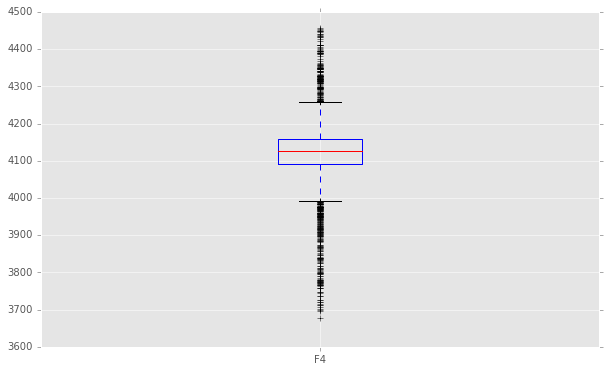

In [3]:
raw.boxplot(column='F4')

### Feature Extraction

To achieve better results, we need to give an input that is representative of what we want the algorithm to learn. In this case, we have to extract the EEG signals of each trial, that correspond to a right or a left blink.

One important observation is that the length between two eye blinks is not the same, due to the unsteady sampling rythm of our device. This means that we can not use the signal itself as an input to the algorithm, since the inputs must be of the same size.

Instead of the signal itself, we can use as input some features extracted from it, which will capture some of the information the signal conveys, with the aim to represent its overall behavior as good as possible. The simplest one we can use are:

* Mean
* Variance

In [4]:
import numpy as np

def extract_features(eeg):
    # Define metrics extracted be the EEG signal
    return [np.mean(eeg),np.std(eeg)]

def construct_dataset(raw,events):    
    # Find the samples where events happened (both left and right)
    events_idx = list(events.ix[events.ix[:,0]<>0].index)
    events_idx.append(max(raw.index))
    
    # Construct the header of the dataset we In order for the algorithm to will use for machine learning 
    # e.g. Channel1_feature1, Channel1_feature2 ... Channel2_feature1, Channel2_feature1
    column_names = []
    for channel in raw:
        column_names.extend([
            channel+'_Mean',
            channel+'_Std'])
    
    # Initiate the dataset (with blank values)
    data = pd.DataFrame(index=range(0,len(events_idx)-1),columns = column_names)

    # Iterate through the events and extract from the EEG signal on the respective samples
    # the features defined in function extract_features. 
    # Add them in the respective row in the dataset (one row for each event)
    for e in range(1,len(events_idx)):
        features = raw.ix[range(events_idx[e-1],events_idx[e]-1),:].apply(extract_features)
        data.ix[e-1,:] = [feature for channel in features for feature in channel]
    
    data = data.convert_objects(convert_numeric=True)
    
    # Define the class of the events (-1 for left, 1 for right)
    data['class'] = np.array(events.ix[events_idx[0:(len(events_idx)-1)]],dtype=float)

    return(data)

# Derive the dataset based on the loaded raw recordings and the events
data = construct_dataset(raw,events)

C:\Users\Giwrgos\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In this way, we can achieve dimensionality reduction, which is generally desirable, since the more the input's dimensions, the more parameters our algorithm has to take into account to perform right classification. However we do have to keep in mind that the information must be sufficient to distinguish between classes.

Since we want to exploit all 5 sessions from each subject, we load them and unite them in a bigger dataset.

We have to note here that most algorithms used in BCI, are trained on a specific subject to perform classification for it. In this tutorial we are going to keep it simple, by using one model for all subjects.

In [5]:
# Append to the dataset the recordings from all subjects and all sessions, using construct_dataset
for sub in range(1,6):
    for ses in range(1,5):
        if sub==1 and ses==1: # recordings from sub 1 ses 1 are allready stored in data
            continue
        raw = pd.read_csv('train\Sub'+str(sub)+'_Ses'+str(ses) +'_raw.csv')    
        events = pd.read_csv('train\Sub'+str(sub)+'_Ses'+str(ses)+'_events.csv',header = None )
        train_sub = construct_dataset(raw,events)
        data = data.append(train_sub,ignore_index=True)

# Make class 0 for left and 1 for right
data['class'] = (data['class']+1)/2

data.to_csv('bci_dataset.csv',index=False)

C:\Users\Giwrgos\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


### Exploratory Data Analysis

Exploratory Data Analysis (EDA) is probably the most basic technique that scientists use to understand their models and come up with conclusions.

Since we aim for a classification task, we can explore the difference of each feature between the two classes. If a given feature seems to behave the same between the two classes, we can simply remove it, since it will probably not be of any help to our algorithm. 

In the examples that follow, we will use boxplots and probability densities  to visualize the interclass difference of a feature.

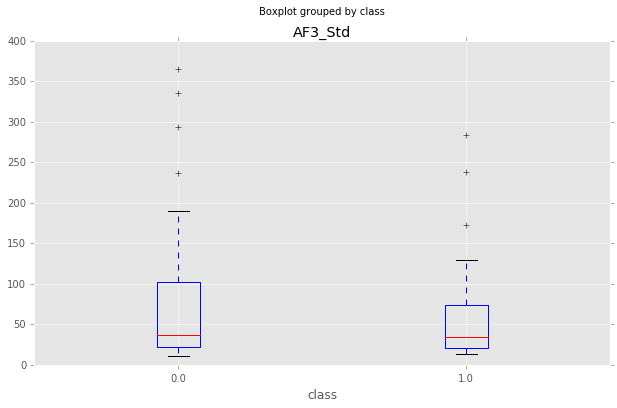

In [6]:
data.boxplot(column='AF3_Std',by='class')

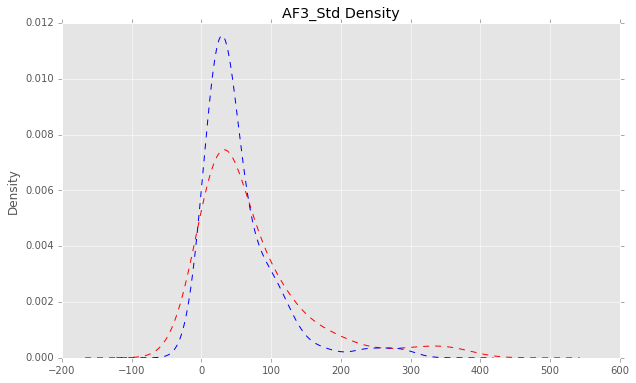

In [7]:
data_right = data.ix[data['class']>0.5,0:data.shape[1]-1]
data_left = data.ix[data['class']<0.5,0:data.shape[1]-1]

data_left['AF3_Std'].plot(kind='density',style='r--')
data_right['AF3_Std'].plot(kind='density',style='b--')
plt.title('AF3_Std Density')

### Neural Networks

For the machine learning part, we are going to use a neural network model, using the library [Keras](http://keras.io/).

We will examine architectures of one hidden layer, while experimenting with the number of nodes, in order to come up with the best one. In order to compare our model's efficiency depending on the number of nodes, we will run some experiments and plot its accuracy and mean squared error. 

Due to the sigmoid function that we will use as an output node in our neural network, we have to "normalize" our data and transform the class in space [0,1].

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

#Normalize data for input in Neural Net
data_normed = (data - data.mean()) / (data.max() - data.min())
data_normed['class']+=0.5

data_normed.to_csv('bci_dataset_normed.csv',index=False)

# Lists that will keep loss and accuracy for all Neural Network Architectures we examine
loss_history = []
acc_history = []

n_features = data_normed.shape[1]-1
n_rows = data_normed.shape[0]

# From pandas data frame to numpy array
train = np.array(data_normed.ix[:,0:n_features])
Y = np.array(data_normed.ix[:,n_features])

for n_nodes in range(1,10):
    print 'nodes used :'+str(n_nodes)
    
    # Define architecture of the model
    model = Sequential([
        Dense(n_nodes, input_dim = data_normed.shape[1]-1,activation='tanh'),
        Dense(1,activation='tanh')
        ])
    
    # Define optimization of the model
    model.compile(loss = 'mse', 
              optimizer = SGD(lr = 0.1),
              metrics = ['accuracy'])
    
    # Fit the model to the data
    result = model.fit(train, Y,
              nb_epoch = 100,
              batch_size = n_rows)
    
    # Keep the resulted train accuracy and train loss
    acc = result.history['acc'][-1]
    loss = result.history['loss'][-1]
    
    print 'loss: '+ str(loss)
    loss_history.append(loss)
    print 'accuracy: '+ str(acc)
    acc_history.append(acc)

Using Theano backend.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


nodes used :1
Epoch 1/100
120/120 [==============================] - 0s - loss: 0.5253 - acc: 0.5000
Epoch 2/100
120/120 [==============================] - 0s - loss: 0.4121 - acc: 0.5000
Epoch 3/100
120/120 [==============================] - 0s - loss: 0.3510 - acc: 0.5000
Epoch 4/100
120/120 [==============================] - 0s - loss: 0.3174 - acc: 0.5000
Epoch 5/100
120/120 [==============================] - 0s - loss: 0.2980 - acc: 0.5000
Epoch 6/100
120/120 [==============================] - 0s - loss: 0.2863 - acc: 0.5000
Epoch 7/100
120/120 [==============================] - 0s - loss: 0.2788 - acc: 0.5083
Epoch 8/100
120/120 [==============================] - 0s - loss: 0.2738 - acc: 0.5167
Epoch 9/100
120/120 [==============================] - 0s - loss: 0.2704 - acc: 0.5000
Epoch 10/100
120/120 [==============================] - 0s - loss: 0.2680 - acc: 0.4583
Epoch 11/100
120/120 [==============================] - 0s - loss: 0.2662 - acc: 0.4833
Epoch 12/100
120/120 [=====

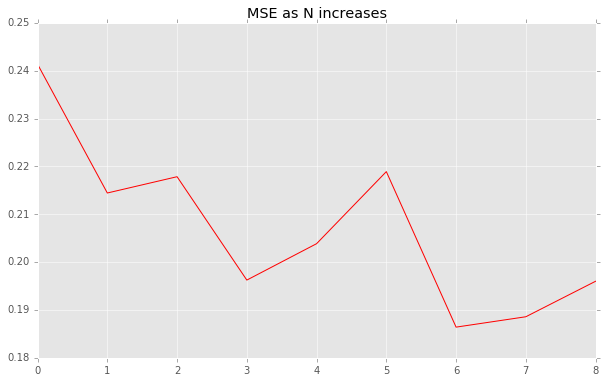

In [9]:
plt.plot(loss_history,color='r')
plt.title('MSE as N increases')

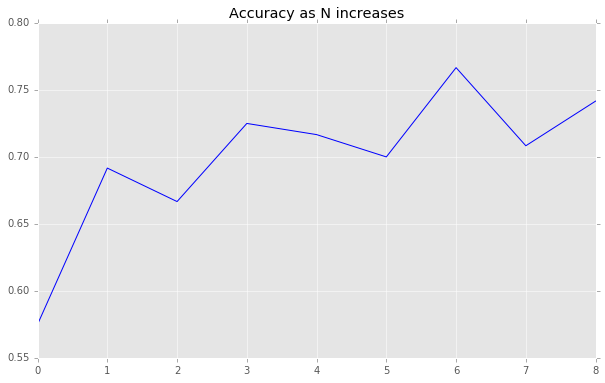

In [10]:
plt.plot(acc_history,color='b')
plt.title('Accuracy as N increases')

### Assesment of Generalization Capability

A machine learning algorithm must be evaluated based on its ability to classify data that he has not been trained on. This is how we can measure how well has the algorithm learned the true underlying "rules" of the data. 

Hence, the final model we choose, will classify data that has never seen again. However, before we choose the final model, we have to find a way to evaluate the model's ability to generalize in unseen data, since its success in the training data is not always a clear indicator. Thus, in order to simulate the test of "unseen data", we devide our initial dataset in two parts, one to train the algorithm with, and another one to test it with the manner we analyze above.

It is common for the model, to perform worse in the test set than in the training one.

In [12]:
from sklearn.cross_validation import train_test_split

# Split the dataset with a ratio of 0.8 - 0.2 (train - simulated test)
train, test = train_test_split(data_normed, test_size = 0.2)
train = np.array(train)
test = np.array(test)

# Set the architecture you believe as optimum
n_nodes_optimum = 5

model = Sequential([
        Dense(n_nodes_optimum, input_dim = data_normed.shape[1]-1,activation='tanh'),
        Dense(1,activation='tanh')
        ])
    
model.compile(loss = 'mse', 
              optimizer = SGD(lr = 0.1),
              metrics = ['accuracy'])

# Last column corresponds to the class, the rest are teh features
model.fit(train[:,0:n_features],
          train[:,n_features],
          nb_epoch=100,
          batch_size = n_rows)

# See the model's performance in the test set
score = model.evaluate( test[:,0:n_features] , test[:,n_features] , batch_size=n_rows)

print 'loss: '+str(score[0])
print 'acc: '+str(score[1])

Epoch 1/100
96/96 [==============================] - 0s - loss: 0.5708 - acc: 0.5000
Epoch 2/100
96/96 [==============================] - 0s - loss: 0.3778 - acc: 0.4688
Epoch 3/100
96/96 [==============================] - 0s - loss: 0.3282 - acc: 0.4792
Epoch 4/100
96/96 [==============================] - 0s - loss: 0.3108 - acc: 0.4688
Epoch 5/100
96/96 [==============================] - 0s - loss: 0.3027 - acc: 0.4062
Epoch 6/100
96/96 [==============================] - 0s - loss: 0.2980 - acc: 0.3854
Epoch 7/100
96/96 [==============================] - 0s - loss: 0.2947 - acc: 0.3646
Epoch 8/100
96/96 [==============================] - 0s - loss: 0.2921 - acc: 0.3750
Epoch 9/100
96/96 [==============================] - 0s - loss: 0.2899 - acc: 0.3646
Epoch 10/100
96/96 [==============================] - 0s - loss: 0.2879 - acc: 0.3542
Epoch 11/100
96/96 [==============================] - 0s - loss: 0.2860 - acc: 0.3438
Epoch 12/100
96/96 [==============================] - 0s - loss

### Classification of Unseen Data

Finally, we are going to train teh algorithm with the optimum architecture, according to our experiments and then proceede to classify some unseen data.

In [14]:
# Train the final model
n_nodes_optimum = 6

train = np.array(data_normed.ix[:,0:n_features])
Y = np.array(data_normed.ix[:,n_features])

model = Sequential([
        Dense(n_nodes_optimum, input_dim = data_normed.shape[1]-1,activation='tanh'),
        Dense(1,activation='tanh')
        ])
    
model.compile(loss = 'mse', 
              optimizer = SGD(lr = 0.1),
              metrics = ['accuracy'])

# Last column corresponds to the class, the rest are the features
model.fit(train,
          Y,
          nb_epoch=100,
          batch_size = n_rows)

Epoch 1/100
120/120 [==============================] - 0s - loss: 0.5286 - acc: 0.5083
Epoch 2/100
120/120 [==============================] - 0s - loss: 0.3435 - acc: 0.4917
Epoch 3/100
120/120 [==============================] - 0s - loss: 0.2864 - acc: 0.5000
Epoch 4/100
120/120 [==============================] - 0s - loss: 0.2666 - acc: 0.4833
Epoch 5/100
120/120 [==============================] - 0s - loss: 0.2583 - acc: 0.4750
Epoch 6/100
120/120 [==============================] - 0s - loss: 0.2542 - acc: 0.4917
Epoch 7/100
120/120 [==============================] - 0s - loss: 0.2519 - acc: 0.5083
Epoch 8/100
120/120 [==============================] - 0s - loss: 0.2503 - acc: 0.5083
Epoch 9/100
120/120 [==============================] - 0s - loss: 0.2491 - acc: 0.5167
Epoch 10/100
120/120 [==============================] - 0s - loss: 0.2482 - acc: 0.5500
Epoch 11/100
120/120 [==============================] - 0s - loss: 0.2473 - acc: 0.5583
Epoch 12/100
120/120 [===================

You can save the model with the best accuracy, since the training with the same parameters does not gurantee that the learning will be exactly the same, due to the optimization randomness.

In [6]:
from keras.models import model_from_json
#save...
json_string = model.to_json()
open('best_architecture.json', 'w').write(json_string)
model.save_weights('best_weights.h5')

#...and reload
model = model_from_json(open('best_architecture.json').read())
model.load_weights('best_weights.h5')

Our test set will include the session 5 of all subjects. The preprocessing of the test data before we "feed" it to the neural network, must be exactly the same as the one we did for the train set. 

In [40]:
# Load the events and raw recordings for the test sessions, the same way as for the train ones
raw = pd.read_csv('test\Sub1_Ses5_raw.csv')    
events = pd.read_csv('test\Sub1_Ses5_events.csv',header=None)
test = construct_dataset(raw,events)

for sub in range(2,6):
    raw = pd.read_csv('test\Sub'+str(sub)+'_Ses5_raw.csv')    
    events = pd.read_csv('test\Sub'+str(sub)+'_Ses5_events.csv',header = None )
    test_sub = construct_dataset(raw,events)
    test = test.append(test_sub,ignore_index=True)
    
# Normalize test set and change class, as in the train set
test['class'] = (test['class']+1)/2
test_normed = (test - test.mean()) / (test.max() - test.min())

# Keep the test class separated for evaluation (+ 0.5 because class should be 0 for left and 1 for right)
test_class = pd.Series(test_normed['class']+0.5)
test_normed = np.array(test_normed.drop('class',1))

C:\Users\Giwrgos\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Finally, we ask from the trained model to classify the classes of every sample in the test set, and use the list with the real classes to measure the classification percentage that was right.

In [53]:
# Create and store predictions
classification = model.predict_classes(test_normed)]
classification =  pd.Series([float(clas) for clas in classification)
pd.DataFrame(classification).to_csv('bci_classification.csv',index=False)

# Calculate the percentage of samples that our model predicted right
accuracy = sum(classification == test_class)/float(len(test_class))

print "Accuracy in the test set is :"+str(accuracy)

# See the differences sample by sample
pd.DataFrame(dict(Classification = classification,Real = test_class))

30/30 [==============================] - 0s
Accuracy in the test set is :0.566666666667


,Predictions,Real
0,1,1
1,0,0
2,0,0
3,1,1
4,1,1
5,0,0
6,1,1
7,1,1
8,1,0
9,1,1
